In [1]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2020-01-01'
end_date = '2024-06-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


                                AAPL        MSFT       GOOG      NVDA  \
Date                                                                    
2020-01-02 00:00:00-05:00  72.620842  153.042267  67.964508  5.971746   
2020-01-03 00:00:00-05:00  71.914825  151.136642  67.630989  5.876163   
2020-01-06 00:00:00-05:00  72.487854  151.527313  69.298576  5.900805   
2020-01-07 00:00:00-05:00  72.146950  150.145737  69.255333  5.972245   
2020-01-08 00:00:00-05:00  73.307510  152.537308  69.801094  5.983446   

                                AMZN  
Date                                  
2020-01-02 00:00:00-05:00  94.900497  
2020-01-03 00:00:00-05:00  93.748497  
2020-01-06 00:00:00-05:00  95.143997  
2020-01-07 00:00:00-05:00  95.343002  
2020-01-08 00:00:00-05:00  94.598503  


In [2]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2024-05-24 00:00:00-04:00,189.095657,426.887054,175.288055,106.426643,180.750000
2024-05-28 00:00:00-04:00,189.105606,427.045868,176.968063,113.855682,182.149994
2024-05-29 00:00:00-04:00,189.404221,425.904633,176.351715,114.779305,182.020004
2024-05-30 00:00:00-04:00,190.399567,411.514923,172.534424,110.456039,179.320007
2024-05-31 00:00:00-04:00,191.355087,411.971405,172.932068,109.589371,176.440002


=== Portfolio Risk Metrics (95% confidence) ===
Historical VaR: -0.0316
Parametric VaR: -0.0319
Monte Carlo VaR: -0.0320
Conditional VaR (CVaR): -0.0452


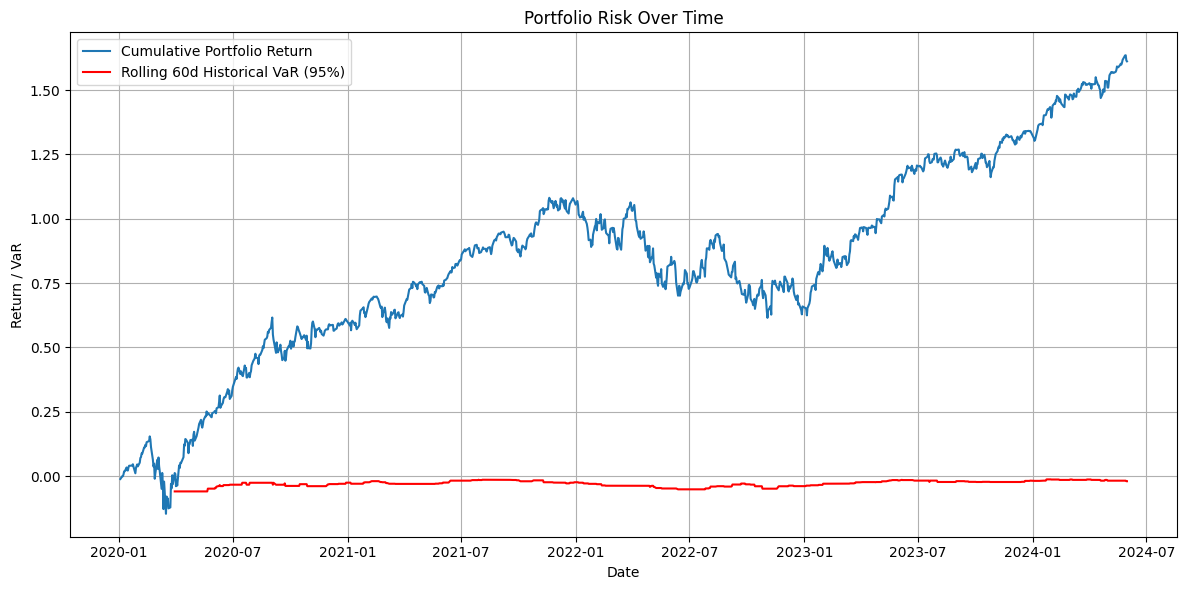

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
#  Calculate daily returns 
returns = data.pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)

confidence_level=0.95
#  Historical VaR 
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100)

#  Parametric VaR (Variance-Covariance, assuming normality) 
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
param_VaR = stats.norm.ppf(1 - confidence_level, mean, std_dev)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = np.random.normal(mean, std_dev, n_simulations)
mc_VaR = np.percentile(simulated_returns, (1-confidence_level)*100)

#  Conditional VaR (CVaR) 
CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

# Print results
print(f"=== Portfolio Risk Metrics ({confidence_level*100:.0f}% confidence) ===")
print(f"Historical VaR: {hist_VaR:.4f}")
print(f"Parametric VaR: {param_VaR:.4f}")
print(f"Monte Carlo VaR: {mc_VaR:.4f}")
print(f"Conditional VaR (CVaR): {CVaR:.4f}")

# Visualization: rolling historical VaR over time 
window = 60  # 60-day rolling window
rolling_VaR = portfolio_returns.rolling(window).apply(
    lambda x: np.percentile(x, (1-confidence_level)*100), raw=False
)

plt.figure(figsize=(12,6))
plt.plot(portfolio_returns.index, portfolio_returns.cumsum(), label='Cumulative Portfolio Return')
plt.plot(rolling_VaR, label=f'Rolling {window}d Historical VaR ({confidence_level*100:.0f}%)', color='red')
plt.title('Portfolio Risk Over Time')
plt.xlabel('Date')
plt.ylabel('Return / VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()